In [1]:
import sklearn
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras

2024-03-14 13:51:20.194434: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 13:51:20.620336: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 13:51:21.155885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 13:51:21.156041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 13:51:21.233942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [ ]:
plt.show()

In [2]:
from imblearn.over_sampling import SMOTE
import time
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
)
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

In [3]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 300)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.max_seq_items", 50)

In [4]:
keras.backend.clear_session()

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        # X = X.T.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000) # Code when made the graphs
        # return X.T
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000, axis=1)
        return X

1. load data

Changed dataset since the previous version, since it turned out that some R848 were of a low concentration.


## Train data

1.3 Add Feature selection

1.1. Add SMOT

In [10]:
training_labels_path = (
    "/home/t.afanasyeva/MAT_rnaseq/gene_counts/20240311_labels_151_samples.csv"
)
training_data_path = (
    "/home/t.afanasyeva/MAT_rnaseq/gene_counts/20240311_training_data_151_samples.csv"
)

In [11]:
training_data = pd.read_csv(training_data_path, index_col="samples")
training_labels = pd.read_csv(training_labels_path, index_col="samples")

In [12]:
training_data.shape, training_labels.shape

((151, 47698), (151, 1))

In [13]:
training_data = training_data.reset_index(drop=True)
training_labels = training_labels.reset_index(drop=True)


sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)
X_train, y_train = sm.fit_resample(training_data, training_labels)

In [14]:
forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)

feature_transformer = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("drop_constant_feature", DropConstantFeatures(tol=0.50)),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("cap_outliers", Winsorizer(capping_method="gaussian", tail="right", fold=3)),
    ]
)

feature_selector = Pipeline(
    [
        ("select_k_best", SelectKBest(chi2, k=1000)),
        (
            "trasnform_and_scale",
            PowerTransformer(method="yeo-johnson", standardize=True),
        ),
        ("select_forest", SelectFromModel(forest, threshold=0.001)),
    ]
)

print("Number of features before: ", X_train.shape[1])
start_time = time.time()

X_train = feature_transformer.fit_transform(X_train)
feature_selector.fit(X_train, y_train)
X_train = feature_selector.transform(X_train)

end_time = time.time()
print("Number of features after: ", X_train.shape[1])
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Number of features before:  47698


/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Number of features after:  322
Elapsed time: 29.62 seconds


1.3 Prepare labels

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()

y_train = le.fit_transform(y_train)

# y_test = le.transform(y_test)

y_train_nn = to_categorical(y_train)
# y_test_nn = to_categorical(y_test)
num_classes = y_train_nn.shape[1]
num_classes

/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


7

2. Initialise Random forest, XGBClassifier, MLPC, NN

In [16]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

In [17]:
# Defines the best parameters for MLPC
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

In [18]:
svc = SVC(kernel="linear", probability=True, gamma=0.7, C=1)
mlpc = MLPClassifier(**params)

In [19]:
# Defines the best parameters for NN
config = {
    "l1": 120,
    "l2": 60,
    "batch_size": 8,
    "activation": "elu",
    "epochs": 400,
    "learning_rate": 0.001,
    "loss": "categorical_crossentropy",
    "dropout_rate1": 0.3,
    "dropout_rate2": 0.8,
}

In [20]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor="loss", patience=10, verbose=0, mode="min", restore_best_weights=True
)

batch_size = config.get("batch_size")
epochs = config.get("epochs")

In [21]:
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.constraints import MaxNorm


def make_model():
    batch_size = config.get("batch_size")
    activation = config.get("activation")
    epochs = config.get("epochs")
    learning_rate = config.get("learning_rate")
    loss = config.get("loss")
    l1 = config.get("l1")
    l2 = config.get("l2")

    dropout_rate1 = config.get("dropout_rate1")
    dropout_rate2 = config.get("dropout_rate2")

    inputs = keras.Input(shape=X_train.shape[1])
    x = keras.layers.UnitNormalization()(inputs)

    x = keras.layers.Dense(
        l1,
        activation=activation,
        kernel_constraint=MaxNorm(3),
        kernel_initializer=HeUniform(),
    )(x)
    x = keras.layers.Dropout(dropout_rate1)(x)

    x = keras.layers.Dense(
        l2,
        activation=activation,
        kernel_constraint=MaxNorm(3),
        kernel_initializer=HeUniform(),
    )(x)
    x = keras.layers.Dropout(dropout_rate2)(x)

    outputs = keras.layers.Dense(6, activation="softmax")(x)

    model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name="MATseq_NN_multiclass_classifier_v0.3",
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
        ],
    )

    return model


nn = make_model()
nn.summary()

2024-03-14 10:46:00.567029: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "MATseq_NN_multiclass_classifier_v0.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 322)]             0         
                                                                 
 unit_normalization (UnitNo  (None, 322)               0         
 rmalization)                                                    
                                                                 
 dense (Dense)               (None, 120)               38760     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                              

In [22]:
models = {
    "LinearSVC": svc,
    "MLPClassifier": mlpc,
    "NeuralNetwork": nn,
}

3. Train models

In [23]:
keras.utils.set_random_seed(2)

In [24]:
for name, model in models.items():
    print(f"Running: {name}")
    if name == "NeuralNetwork":
        model.fit(
            X_train,
            y_train_nn,
            epochs=epochs,
            batch_size=batch_size,
            verbose=True,
            callbacks=[earlystopper],
        )
    else:
        model.fit(X_train, y_train)

Running: LinearSVC
Running: MLPClassifier
Running: NeuralNetwork
Epoch 1/400


ValueError: in user code:

    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 7) and (None, 6) are incompatible


## Test data

In [ ]:
path = "/home/t.afanasyeva/MAT_rnaseq/gene_counts/20240224_complete_dataset_274_samples.csv"
data = pd.read_csv(path, index_col="samples")

Starting feature transform for HKSA|HKEB
Number of features before:  47698
Number of features after:  317
Elapsed time: 12.08 seconds
LinearSVC


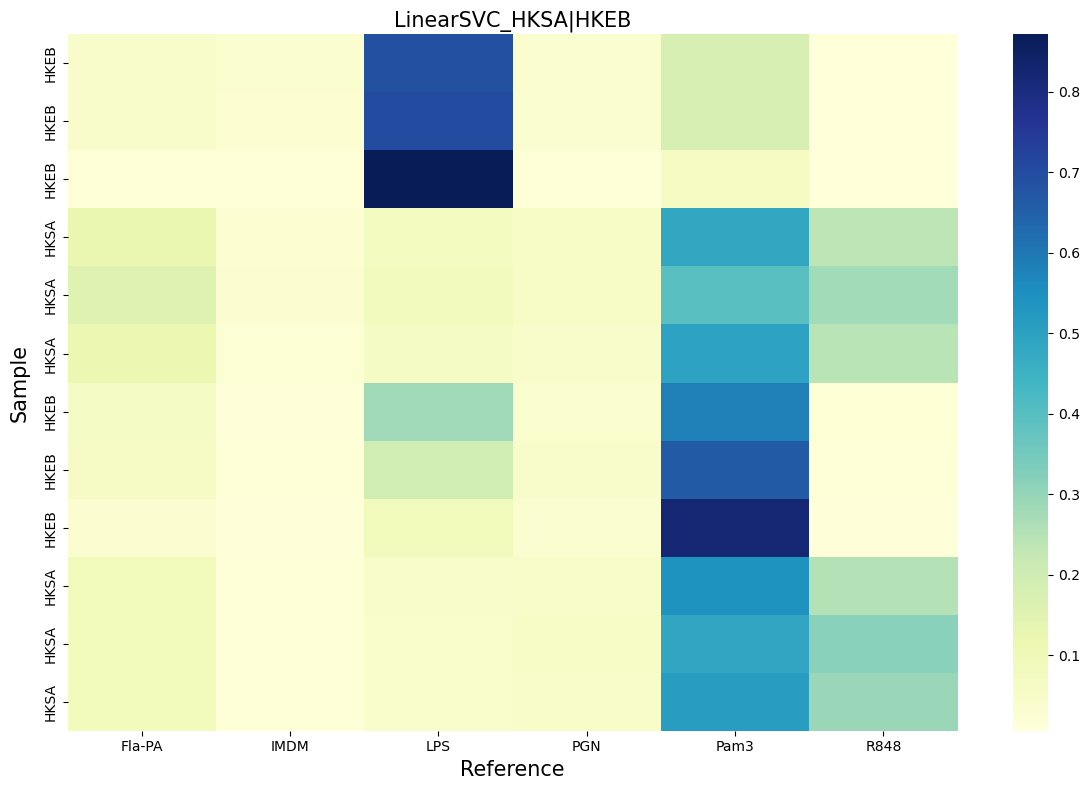

MLPClassifier


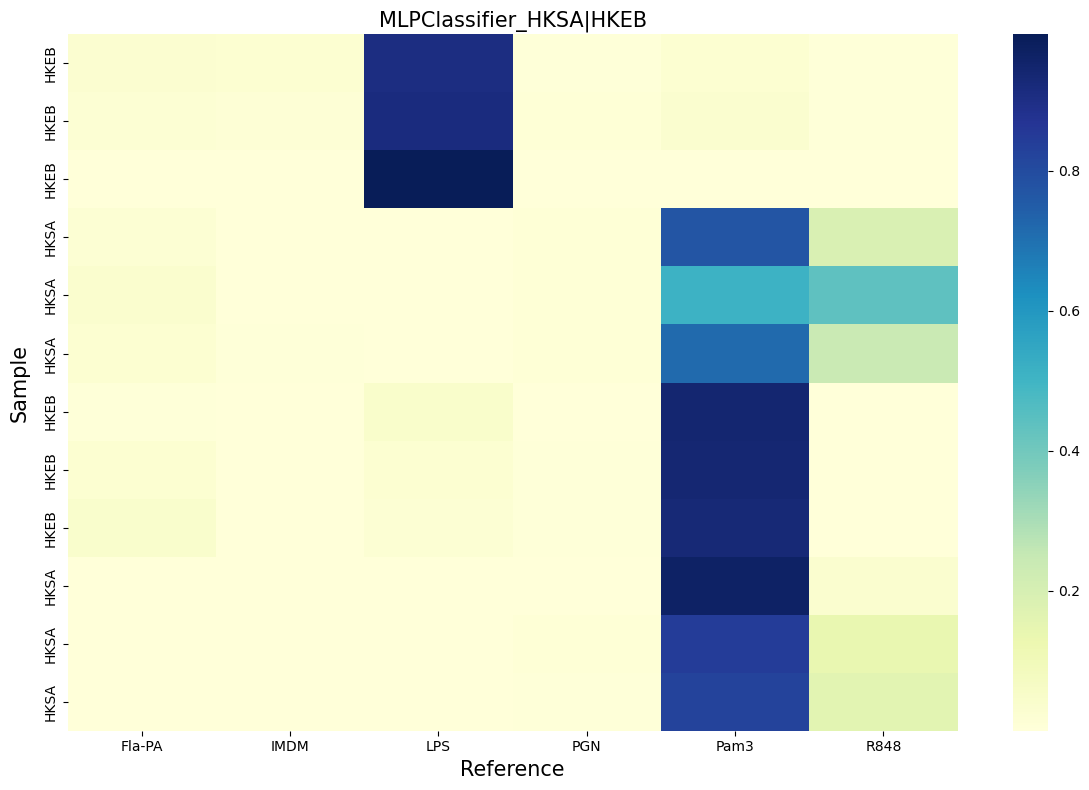

NeuralNetwork
1/1 [==============================] - 0s 69ms/step


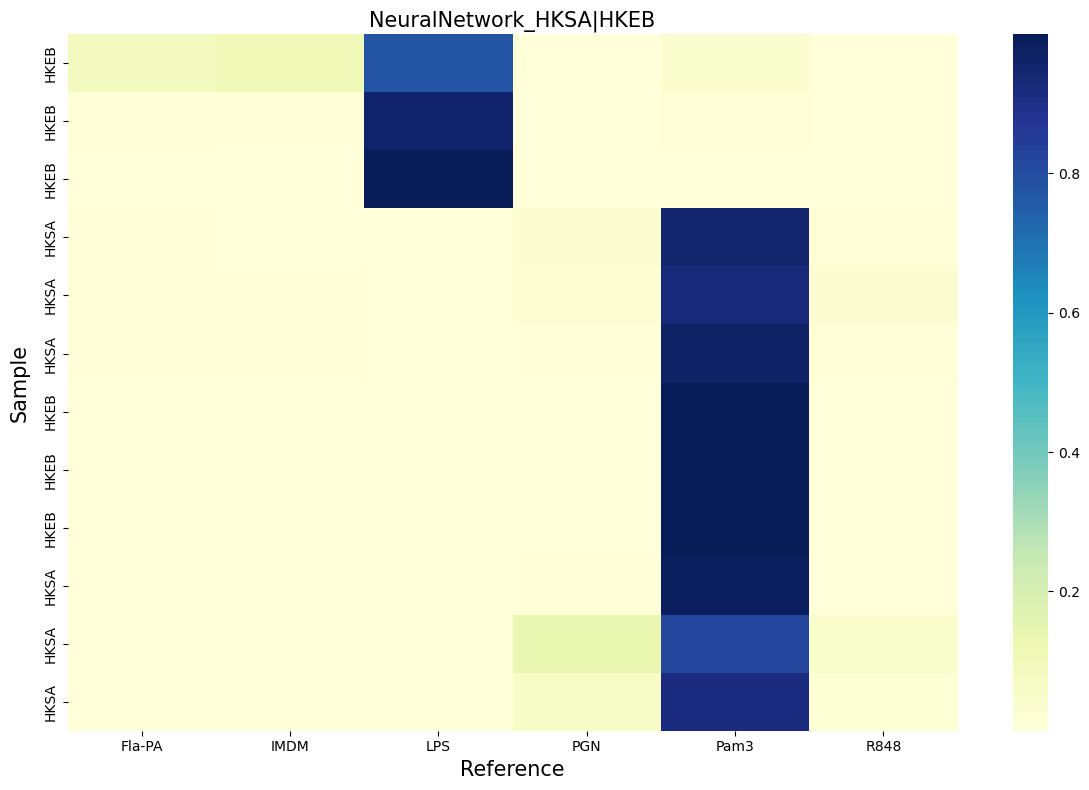

Starting feature transform for nanogam
Number of features before:  47698
Number of features after:  317
Elapsed time: 11.93 seconds
LinearSVC


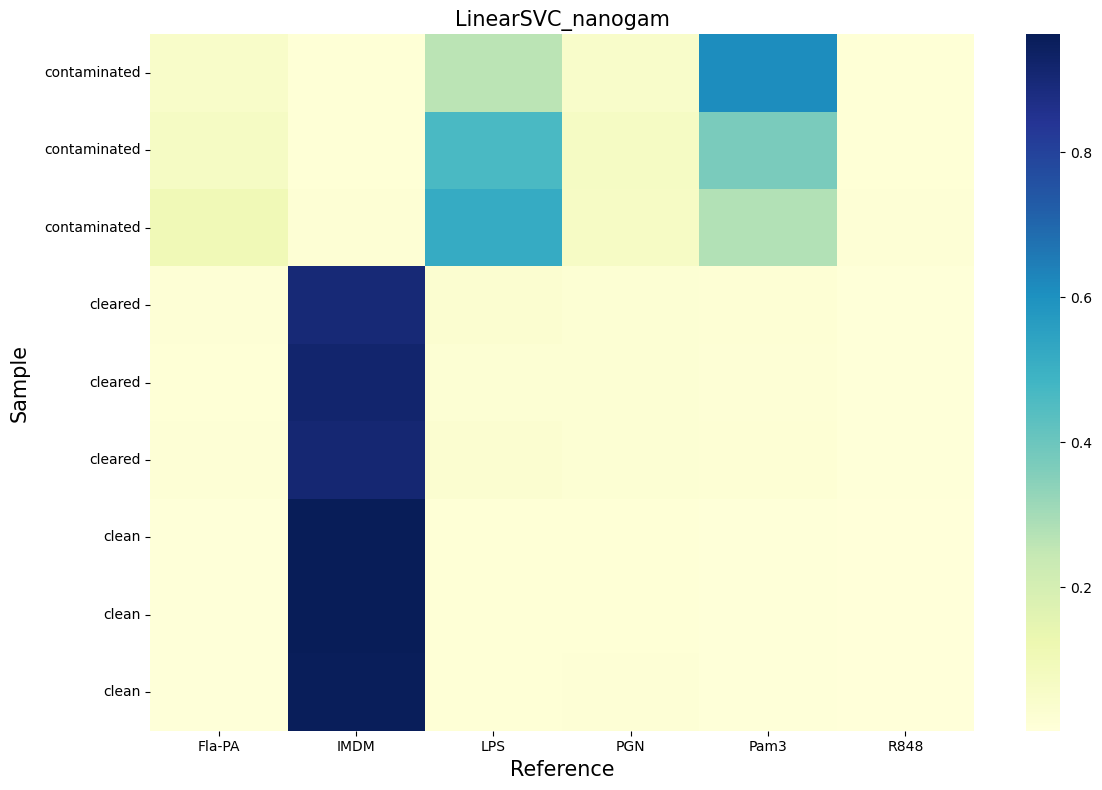

MLPClassifier


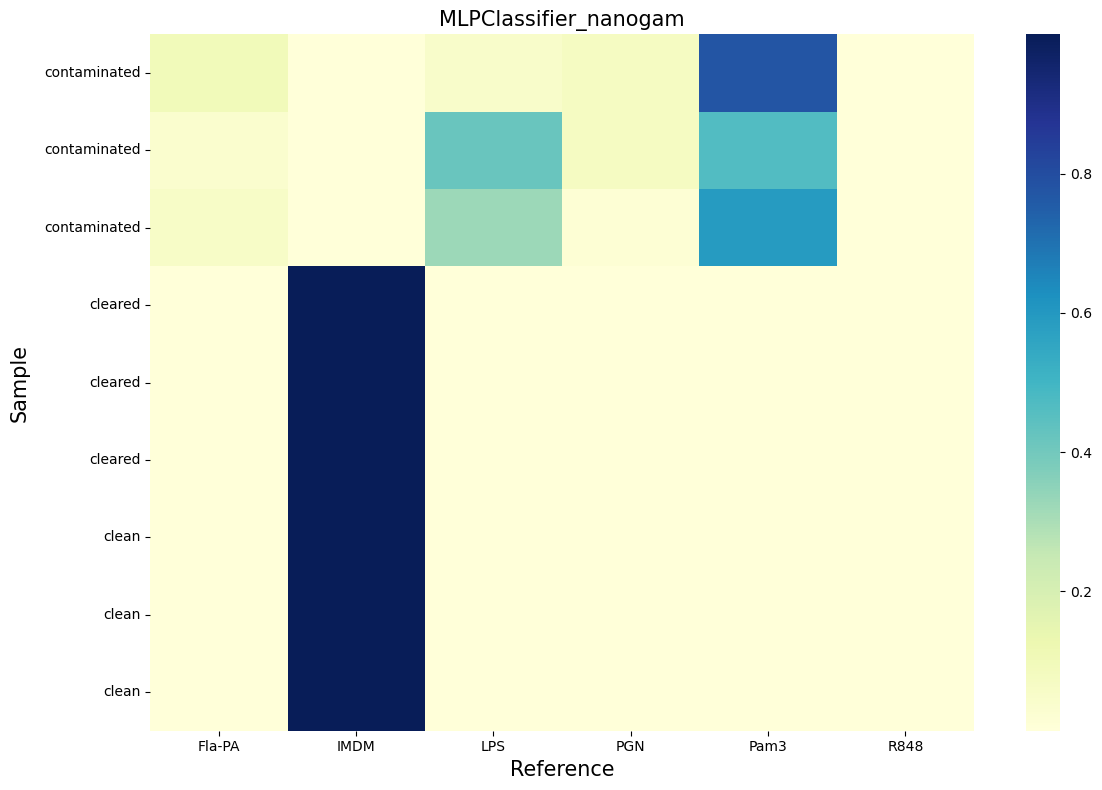

NeuralNetwork
1/1 [==============================] - 0s 19ms/step


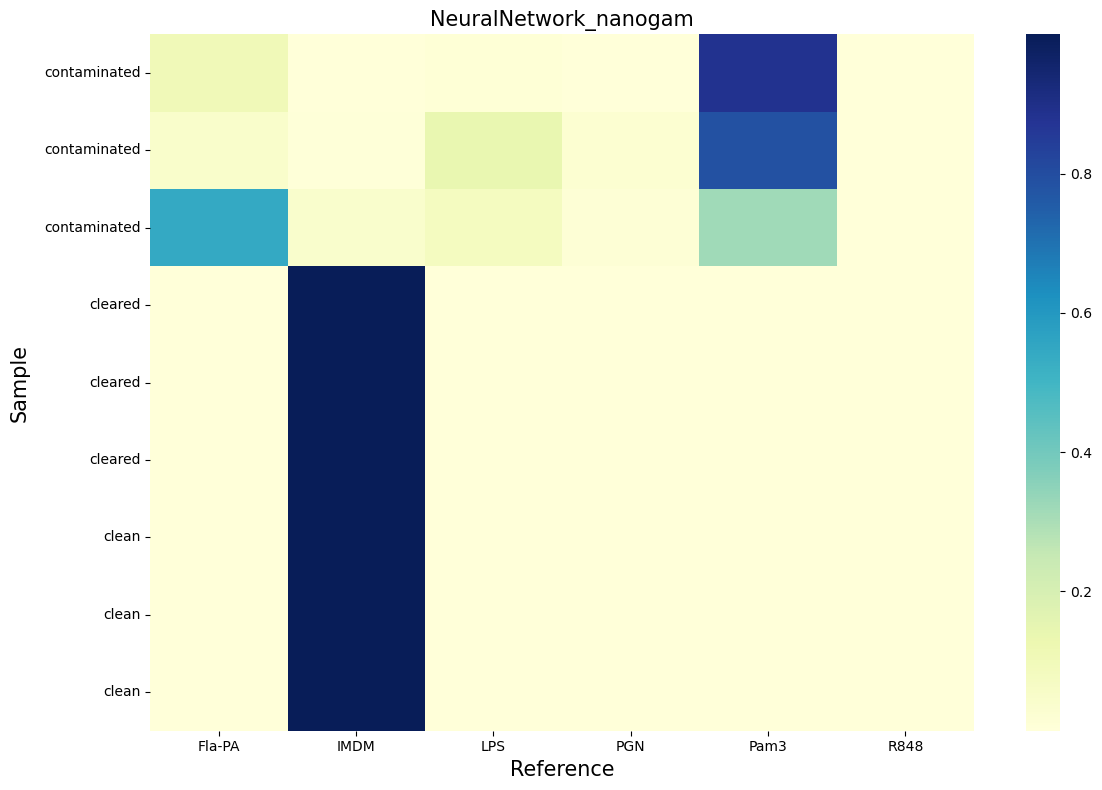

Starting feature transform for Pam3-PGN|LPS-PGN|Pam3-R848
Number of features before:  47698
Number of features after:  317
Elapsed time: 11.87 seconds
LinearSVC


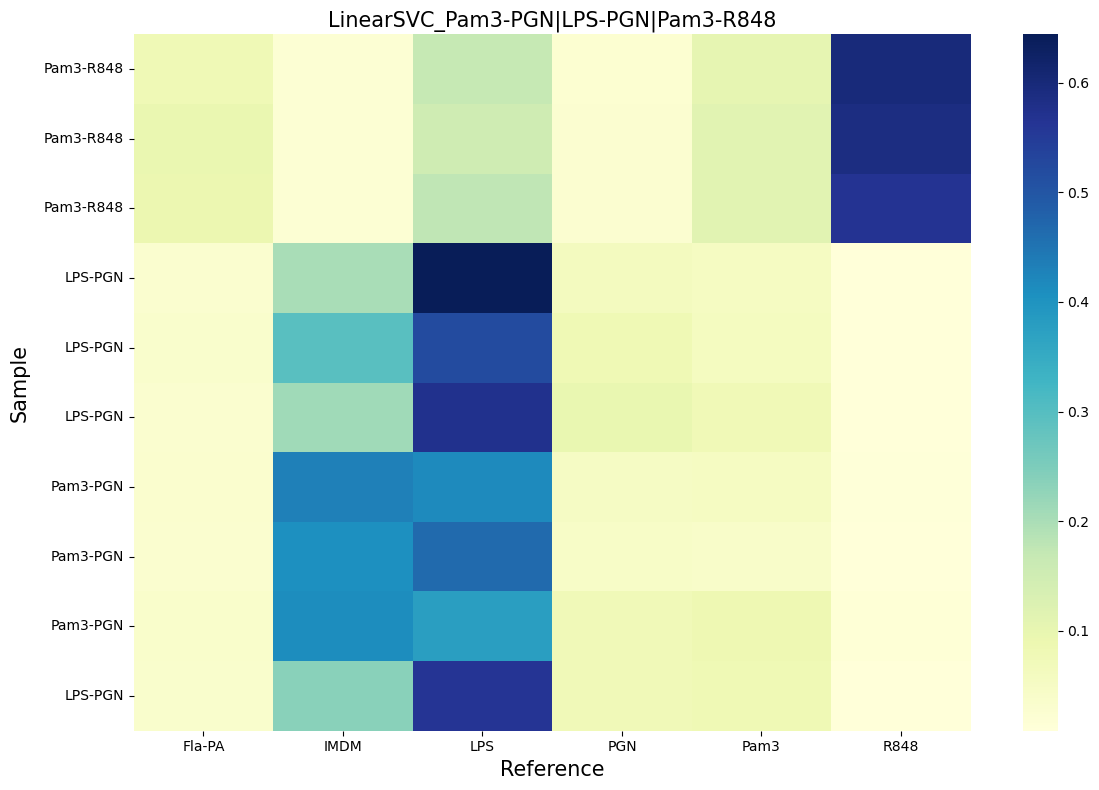

MLPClassifier


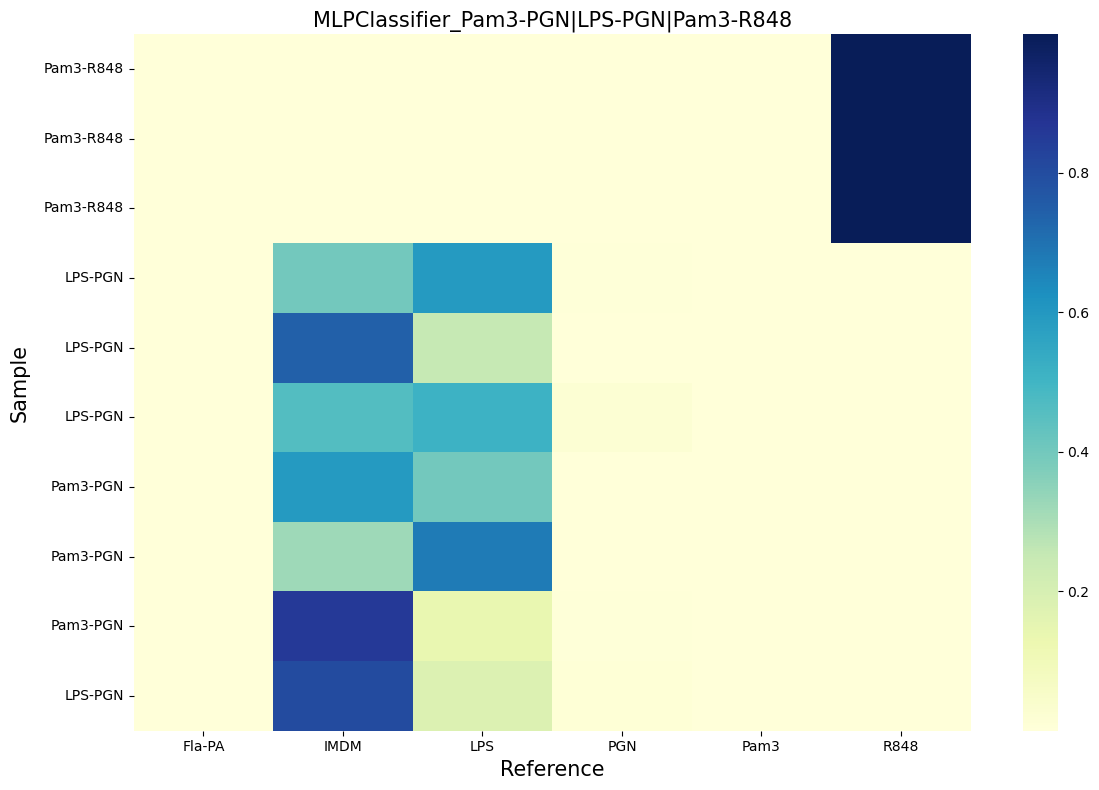

NeuralNetwork
1/1 [==============================] - 0s 19ms/step


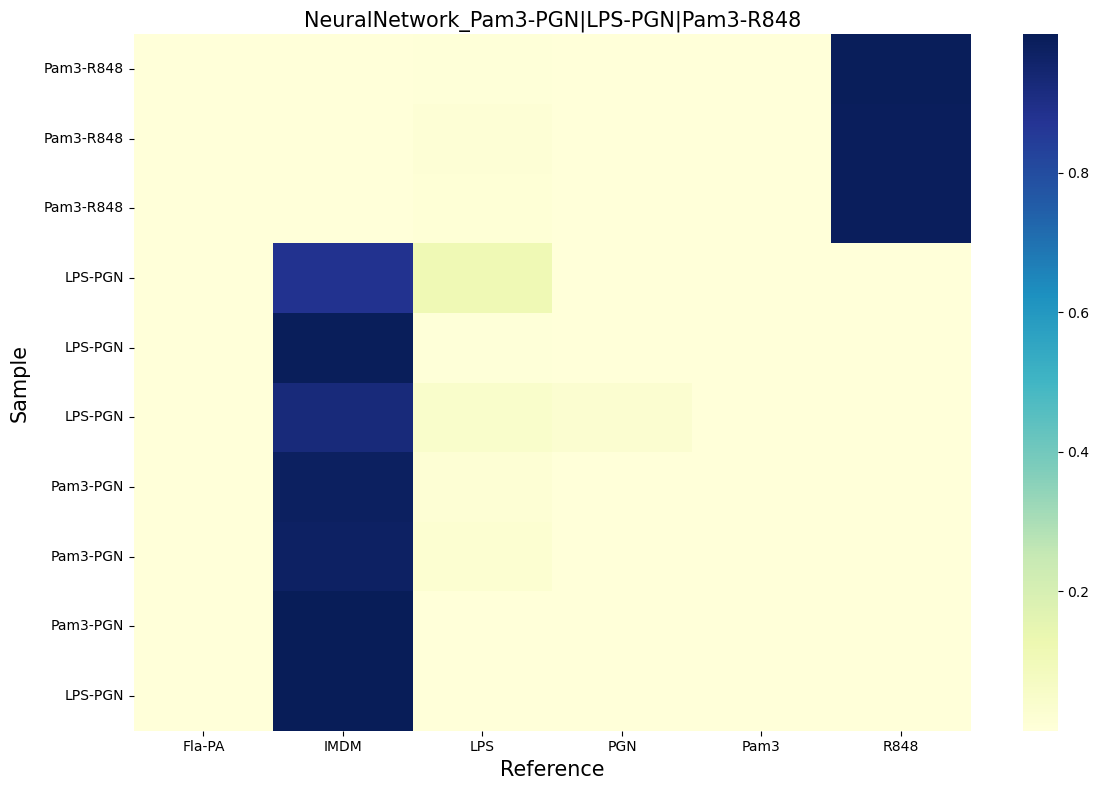

Starting feature transform for Alb
Number of features before:  47698
Number of features after:  317
Elapsed time: 12.08 seconds
LinearSVC


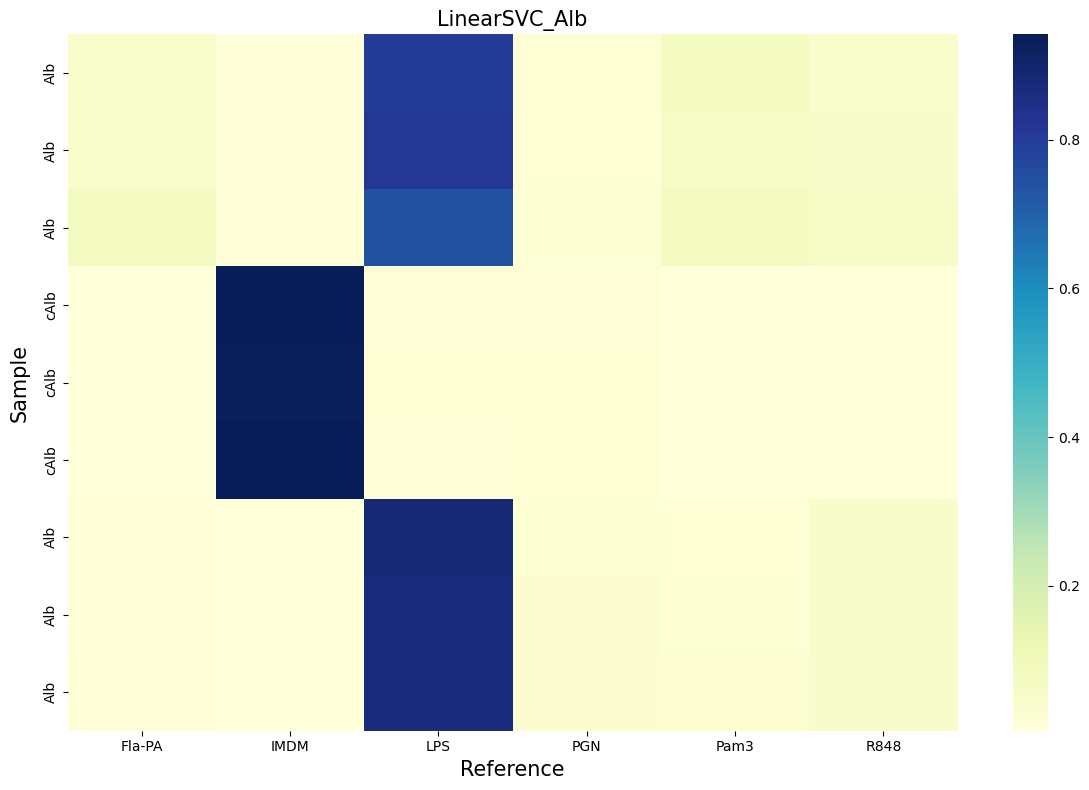

MLPClassifier


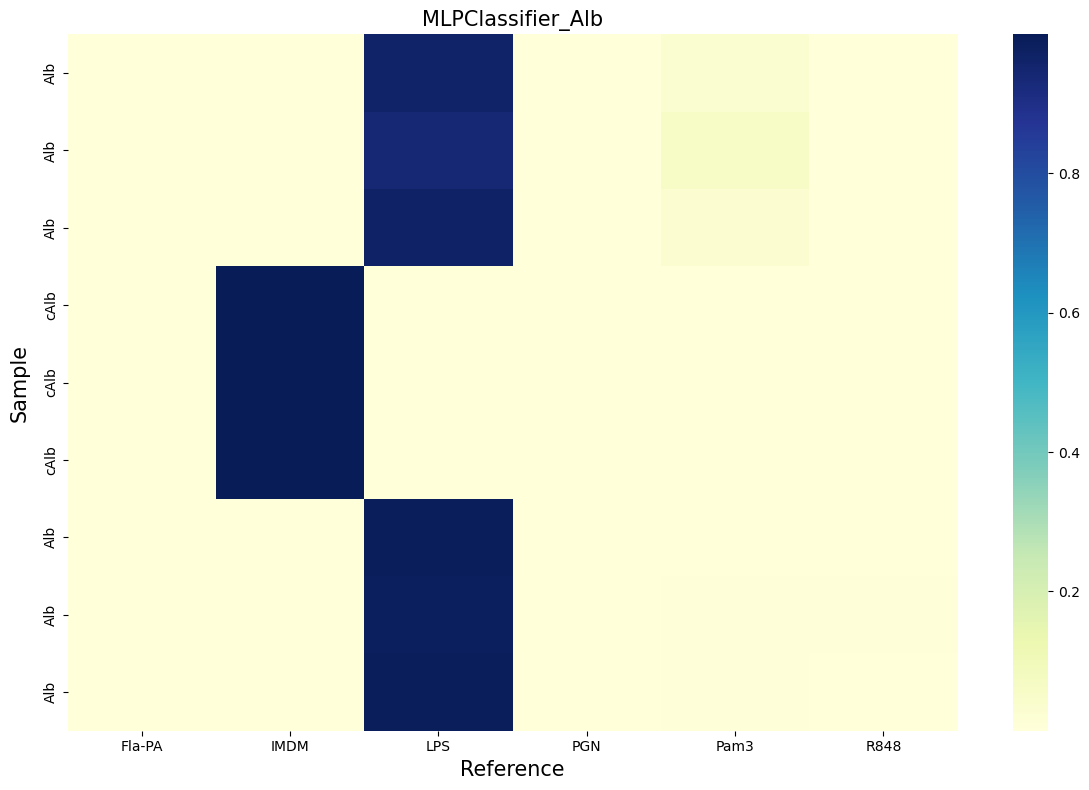

NeuralNetwork
1/1 [==============================] - 0s 18ms/step


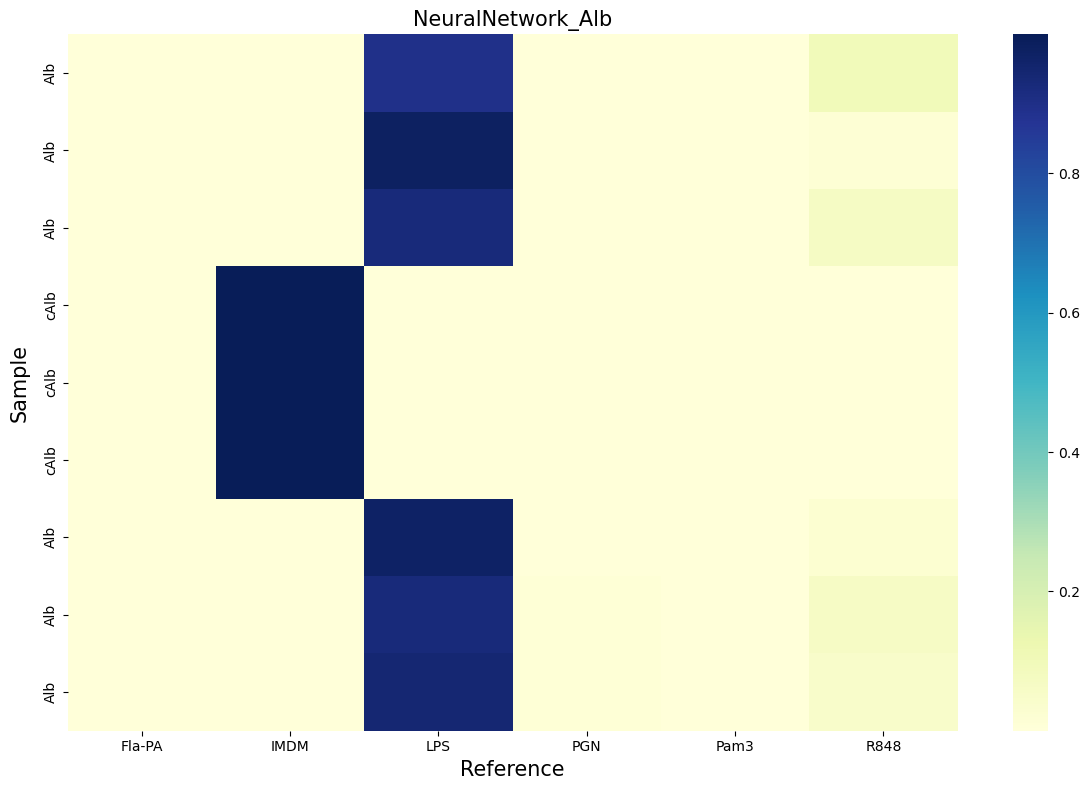

In [ ]:
included_subsets = ["HKSA|HKEB", "nanogam", "Pam3-PGN|LPS-PGN|Pam3-R848", "Alb"]

for subset in included_subsets:

    df_subset = data[data.index.str.contains(subset)]

    test_labels = []
    for i in df_subset.index:
        test_labels.append(i.split("_")[2])

    y_test = test_labels

    X_test = df_subset.reset_index(drop=True)

    print(f"Starting feature transform for {subset}")
    print("Number of features before: ", X_test.shape[1])
    start_time = time.time()

    X_test = feature_transformer.transform(X_test)
    X_test = feature_selector.transform(X_test)

    end_time = time.time()
    print("Number of features after: ", X_test.shape[1])
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

    predictions = []
    model_names = []
    output = pd.DataFrame()

    for name, model in models.items():
        print(f"{name}")
        if name == "NeuralNetwork":
            test_pred = pd.DataFrame(
                model.predict(X_test), columns=list(le.classes_), index=y_test
            )

        else:
            test_pred = pd.DataFrame(
                model.predict_proba(X_test),
                columns=list(le.classes_),
                index=list(y_test),
            )

        plt.figure(figsize=(12, 8))

        heat = sns.heatmap(test_pred, cmap="YlGnBu")
        # Adjust layout for the plot
        heat.set_title(f"{name}_{subset}", fontsize=15)
        heat.set_xlabel("Reference", fontsize=15)
        heat.set_ylabel("Sample", fontsize=15, labelpad=10)

        plt.savefig(f"{name}_{subset}_predictions.png", bbox_inches="tight")
        plt.tight_layout()

        plt.show()